## Importing Modules

In [161]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


## Data Preprocessing
### Handles loading, labeling, and cleaning step detection data from CSV files.

In [162]:
class DataPreprocessor:
    "Class to load, label, and clean step detection data."

    def __init__(self, root_dir) -> None:
        self.root_dir = root_dir

    def getStepMixedFile(self, dirName, fileName):
        return dirName + 'awindaRecording_' + fileName.split('_')[1] + '.csv.stepMixed'

    def mapLabels(self, data, labels):
        k = 10
        data = pd.DataFrame(data)
        for index, row in labels.iterrows():
            data.loc[row[0]:row[0] + k, 'start'] = 1
            data.loc[row[1] - k:row[1], 'end'] = 1
        return data

    def takeStepMixesItem(self, item):
        return item[0]

    def sortLabeles(self, labeles):
        labeles = labeles.tolist()
        labeles.sort(key=self.takeStepMixesItem)
        return labeles

    def load_data(self):
        "Load all dataset from the root directory"
        dir_list = os.listdir(self.root_dir)
        dir_list = self.remove_testData(dir_list)
        
        result = []
        result_cleaned = []

        for dir in dir_list:
            dir = self.root_dir + '/' + dir + '/'
            files = glob.glob(dir + "*.csv")

            dir_labeled_data = []
            dir_labeled_cleaned_data = []

            for file in files:
                data = pd.read_csv(file)
                data['start'] = 0
                data['end'] = 0

                label_file = self.getStepMixedFile(dir, file.split('/')[-1].split('.')[0])
                labels = pd.read_csv(label_file, header=None)

                labeled_data = self.mapLabels(data, labels)
                cleaned_data = self.clean(labeled_data, labels)

                print(f"Cleaned data for {file}, {len(cleaned_data)}")

                dir_labeled_data.append(labeled_data)
                dir_labeled_cleaned_data.append(cleaned_data)

            concat_data = pd.concat(dir_labeled_data).reset_index(drop=True)
            concat_cleaned_data = pd.concat(dir_labeled_cleaned_data).reset_index(drop=True)

            result.append(concat_data)
            result_cleaned.append(concat_cleaned_data)

        return (pd.concat(result).reset_index(drop=True), pd.concat(result_cleaned).reset_index(drop=True))

    def remove_testData(self, dir_list):
        try:
            dir_list.remove('testdata.csv')
        except ValueError:
            pass
        return dir_list

    def checkHasNextStep(self, labels, end_idx):
        for _, label in labels.iterrows():
            start = label[0]
            if start == end_idx:
                return True
        return False

    def clean(self, labeled_data, labels):
        "Clean data by removing ranges between steps"
        labeled_data = pd.DataFrame(labeled_data)

        labels = self.sortLabeles(labels.to_numpy())
        labels = pd.DataFrame(labels)

        start_idx = labels.iloc[0][0]
        last_idx = labels.iloc[-1][1]

        idx_to_drop = []

        for _, label in labels.iterrows():
            start = label[0]
            end = label[1]

            j = 1
            while not self.checkHasNextStep(labels, end + j):
                j += 1
                if end + j > last_idx:
                    j = (len(labeled_data)) - (last_idx + 1)
                    break
            if j > 1:
                idx_range = [end + 1, end + j + 1]
                idx_to_drop.append(idx_range)

        date_frame_copy = labeled_data.to_numpy()
        k = 0
        for idx_range in idx_to_drop:
            date_frame_copy = np.delete(date_frame_copy, slice(idx_range[0] - k, idx_range[1] - k), 0)
            k += idx_range[1] - idx_range[0]

        # Remove start samples
        date_frame_copy = self.removeStartSamples(start_idx, date_frame_copy)
        return pd.DataFrame(date_frame_copy).reset_index(drop=True)

    def removeStartSamples(self, start_idx, labeled_data):
        l = np.delete(labeled_data, slice(0, start_idx), 0)
        return pd.DataFrame(l)


## Model Architectures

### MLP MODEL

In [163]:
# MLP Model
class ModelMLP:
    def __init__(self, in_dim, hidden_dim, class_dim, lr) -> None:
        self.model = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, class_dim),
            nn.Sigmoid()
        )
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss_func = nn.CrossEntropyLoss()

### GRU MODEL

In [164]:
# Custom GRU Model
class CustomGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(CustomGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return self.sigmoid(out)


class ModelGRU:
    def __init__(self, input_size, output_size, hidden_dim, n_layers, lr) -> None:
        self.model = CustomGRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_func = nn.MSELoss()

### LSTM MODEL

In [165]:

# Custom LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm1 = nn.LSTMCell(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.lstm2 = nn.LSTMCell(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        out1, _ = self.lstm1(input)
        out1 = self.dropout1(out1)

        out2, _ = self.lstm2(out1)
        out2 = self.dropout2(out2)

        out = self.fc(out2)
        return self.sigmoid(out)


class ModelLSTM:
    def __init__(self, input_size, hidden_size, output_size, dropout_rate, lr) -> None:
        self.model = LSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dropout_rate=dropout_rate)
        self.loss_func = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

## Model Initialization

In [166]:
def getModels(modelName):
    m1 = ModelMLP(6, 64, 2, 0.01)
    m2 = ModelGRU(input_size=6, output_size=2, hidden_dim=64, n_layers=2, lr=0.001)
    m3 = ModelLSTM(input_size=6, hidden_size=6, output_size=2, dropout_rate=0.2, lr=0.001)

    if modelName == 'm1': return m1
    elif modelName == 'm2': return m2
    elif modelName == 'm3': return m3


## Dataset Class

In [167]:
class StepDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


## Training Functions

In [168]:
def trainModel(model, train_loader, epochs):
    train_loss_per_epoch = []

    for epoch in range(epochs):
        train_loss = 0.0

        for inputs, labels in train_loader:
            model.optimizer.zero_grad()
            outputs = model.model(inputs)
            loss = model.loss_func(outputs, labels)
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        train_loss_per_epoch.append(avg_loss)
    
    return model, train_loss_per_epoch

def plot(metric1, metric2, metric3, 
         m1_label, m2_label, m3_label, 
         x_label, y_label, title, 
         color1='blue', color2='orange', color3='green'):
    
    plt.plot(metric1, label=m1_label, color=color1)
    
    if metric2:
        plt.plot(metric2, label=m2_label, color=color2)
    
    if metric3:
        plt.plot(metric3, label=m3_label, color=color3)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()





## Main Execution

In [169]:
# Initialize data preprocessor
dataPreprocessor = DataPreprocessor('./data')

# Load raw and cleaned data
data, cleaned_data = dataPreprocessor.load_data()

# Prepare training arrays from cleaned_data
x_train = []
y_train = []

for _, row in cleaned_data.iterrows():
    features = [row[1], row[2], row[3], row[4], row[5], row[6]]
    labels = [row[7], row[8]]
    x_train.append(features)
    y_train.append(labels)

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

train_dataset = StepDataset(x_train, y_train)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)

print(f"Training dataset size: {len(train_dataset)}")




Cleaned data for ./data/person_8/ClippedawindaRecording_20230217130617.csv, 26631
Cleaned data for ./data/person_12/ClippedawindaRecording_20230403155903.csv, 24020
Cleaned data for ./data/person_12/ClippedawindaRecording_20230403160632.csv, 25683
Cleaned data for ./data/perosn_2/ClippedawindaRecording_20230217132921.csv, 22381
Cleaned data for ./data/person_5/ClippedawindaRecording_20230217123216.csv, 29023
Cleaned data for ./data/person_3/ClippedawindaRecording_20230217125431.csv, 29965
Cleaned data for ./data/person_4/ClippedawindaRecording_20230124152114.csv, 27073
Cleaned data for ./data/person_4/ClippedawindaRecording_20230206161506.csv, 24995
Cleaned data for ./data/person_4/ClippedawindaRecording_20230206162219.csv, 17695
Cleaned data for ./data/person_4/ClippedawindaRecording_20230206154634.csv, 24358
Cleaned data for ./data/person_4/ClippedawindaRecording_20230124153538.csv, 11904
Cleaned data for ./data/person_4/ClippedawindaRecording_20230124151117.csv, 17870
Cleaned data f

In [170]:
print("Shape of dataset:", data.shape)
print("Raw data shape:", data.shape)
print("Cleaned data shape:", cleaned_data.shape)

Shape of dataset: (722582, 9)
Raw data shape: (722582, 9)
Cleaned data shape: (576480, 9)


In [171]:

print("\nColumn types:\n", data.dtypes)
print("\nMissing values:\n", data.isnull().sum())
data.tail(5)
print(f"Training dataset size: {len(train_dataset)}")


Column types:
  Activity      int64
 AccelX_5    float64
 AccelY_5    float64
 AccelZ_5    float64
 GyroX_5     float64
 GyroY_5     float64
 GyroZ_5     float64
start          int64
end            int64
dtype: object

Missing values:
  Activity    0
 AccelX_5    0
 AccelY_5    0
 AccelZ_5    0
 GyroX_5     0
 GyroY_5     0
 GyroZ_5     0
start        0
end          0
dtype: int64
Training dataset size: 576480


In [172]:
data.head(5)

,Activity,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5,start,end
0,0,1.370639,3.077730,-9.138201,0.026021,-0.025069,0.026772,0,0
1,0,1.380689,3.039416,-9.200333,0.038649,-0.038450,0.035676,0,0
2,0,1.378264,2.981465,-9.305405,0.043459,-0.038100,0.031424,0,0
3,0,1.423814,2.944719,-9.343213,0.042548,-0.028578,0.029073,0,0
4,0,1.422443,2.946009,-9.392369,0.027376,-0.014168,0.016098,0,0


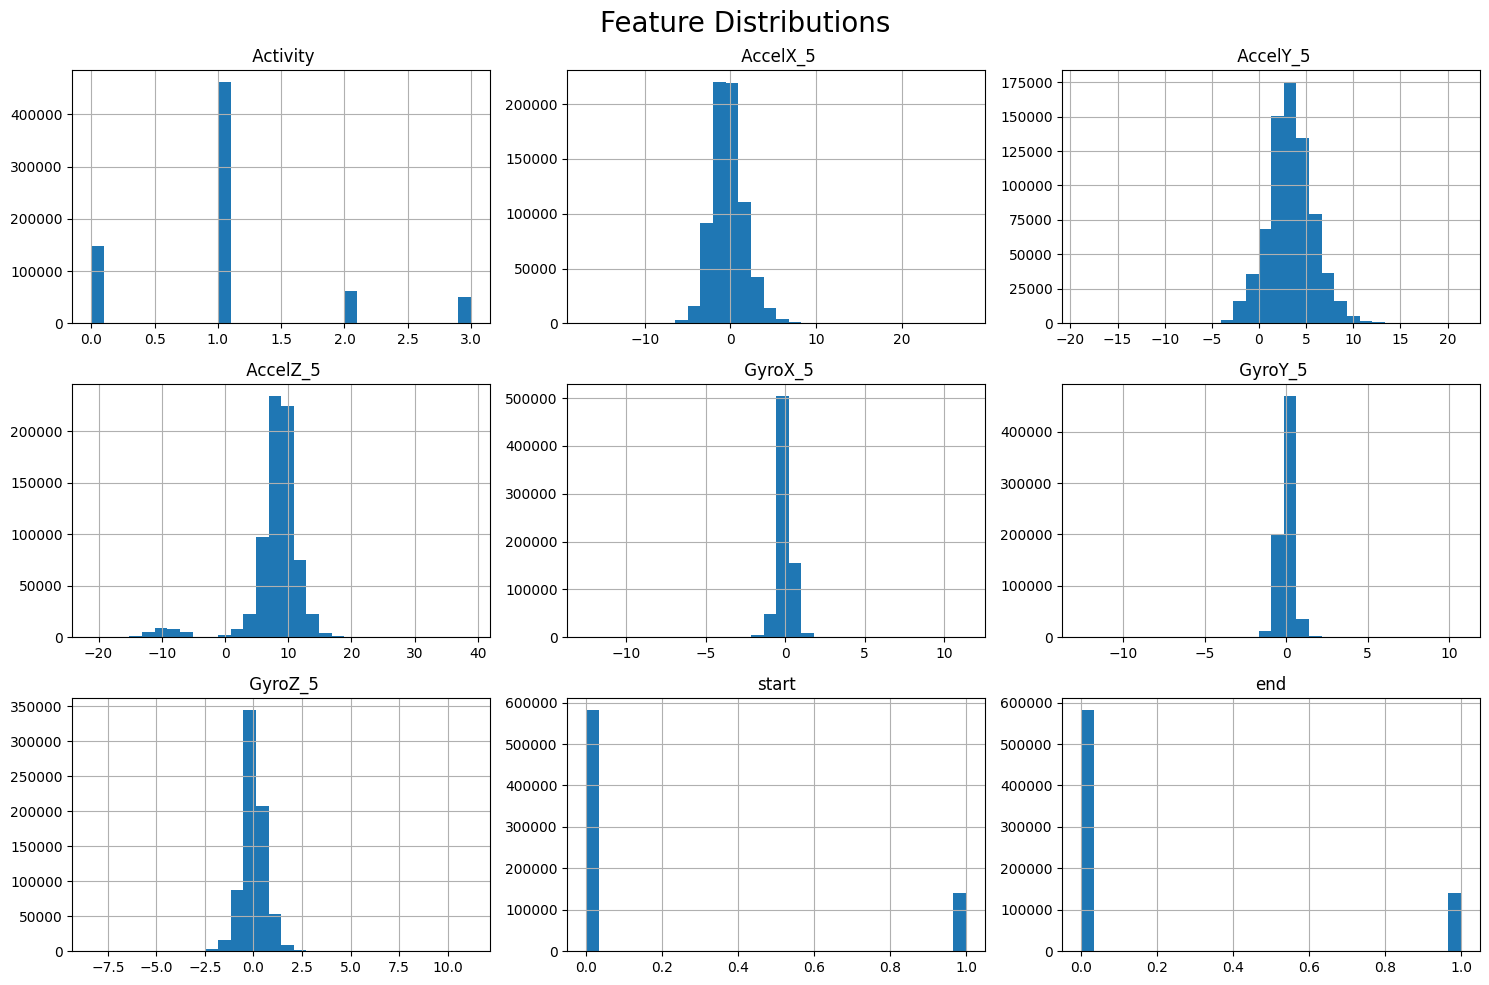

In [173]:


data.hist(bins=30, figsize=(15, 10))
plt.suptitle("Feature Distributions", fontsize=20)
plt.tight_layout()
plt.show()




## Results

### Training Loss Curves

Epoch [1/5], Loss: 0.3088
Epoch [2/5], Loss: 0.3061
Epoch [3/5], Loss: 0.3007
Epoch [4/5], Loss: 0.2976
Epoch [5/5], Loss: 0.2945


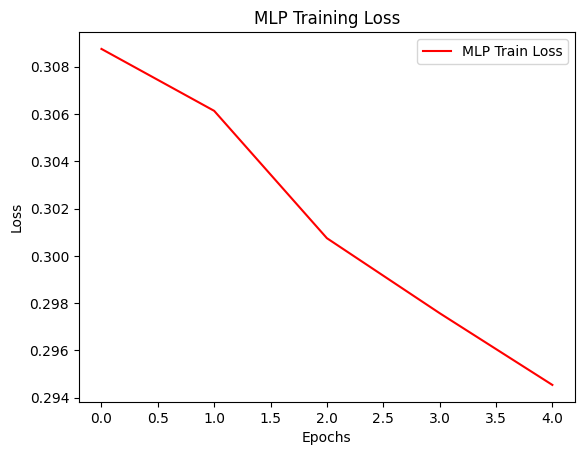

Epoch [1/2], Loss: 0.0962
Epoch [2/2], Loss: 0.0830


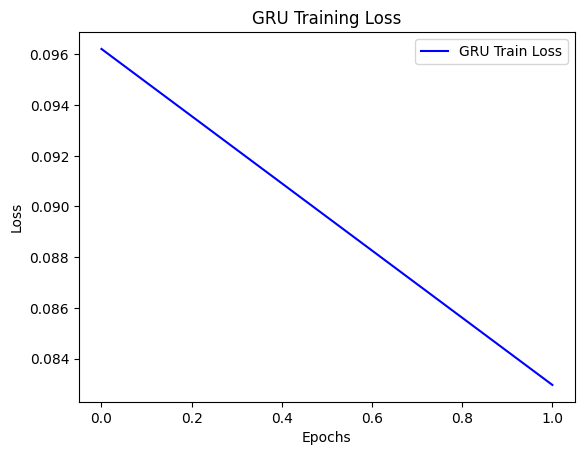

Epoch [1/5], Loss: 0.4880
Epoch [2/5], Loss: 0.4502
Epoch [3/5], Loss: 0.4441
Epoch [4/5], Loss: 0.4419
Epoch [5/5], Loss: 0.4401


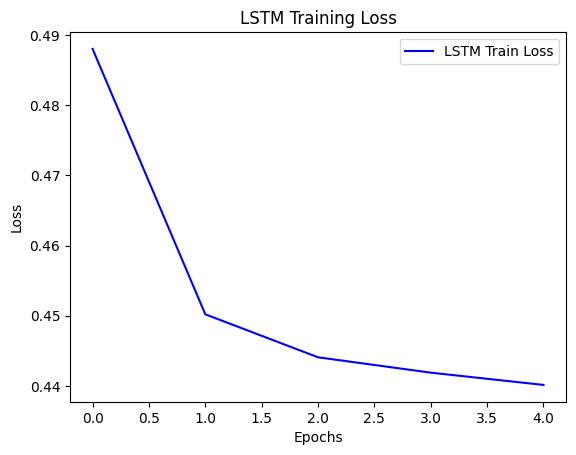

In [174]:
# --- Train and plot MLP ---
mlpModel = getModels('m1')
mlpModel, mlp_loss = trainModel(mlpModel, train_loader, epochs=5)
plot(mlp_loss, [], None, 'MLP Train Loss', '', '', 'Epochs', 'Loss', 'MLP Training Loss', color1='red')

# --- Train and plot GRU ---
gruModel = getModels('m2')
gruModel, gru_loss = trainModel(gruModel, train_loader, epochs=2)
plot(gru_loss, [], None, 'GRU Train Loss', '', '', 'Epochs', 'Loss', 'GRU Training Loss', color2='green')


# --- Train and plot LSTM ---
lstmModel = getModels('m3')
lstmModel, lstm_loss = trainModel(lstmModel, train_loader, epochs=5)
plot(lstm_loss, [], None, 'LSTM Train Loss', '', '', 'Epochs', 'Loss', 'LSTM Training Loss', color3='blue')

In [175]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load test dataset
test_df = pd.read_csv('./data/testdata.csv')

# Clean up column names (strip whitespace)
test_df.columns = test_df.columns.str.strip()

# Prepare input features
features = test_df[['AccelX_5', 'AccelY_5', 'AccelZ_5', 'GyroX_5', 'GyroY_5', 'GyroZ_5']].to_numpy(dtype=np.float32)

# Prepare labels
labels = test_df[['start', 'end']].to_numpy(dtype=np.float32)

# Convert to tensor
test_x = torch.tensor(features)
test_y = torch.tensor(labels)


In [176]:
lstmModel.model.eval()
with torch.no_grad():
    outputs = lstmModel.model(test_x)

# Convert predictions to numpy
predicted = outputs.numpy()


In [177]:
pred_labels = (predicted > 0.5).astype(int)

accuracy = (pred_labels == labels).mean()
print(f'Accuracy: {accuracy*100:.2f}%')



Accuracy: 95.50%


In [178]:
import pandas as pd

# Assuming pred_labels is a numpy array of shape (num_samples, 2)
df_pred = pd.DataFrame(pred_labels, columns=['Predicted_Start', 'Predicted_End'])

# Save to CSV
df_pred.to_csv('predicted_labels.csv', index=False)

# To display the first few rows, just use:
print(df_pred)



        Predicted_Start  Predicted_End
0                     0              0
1                     0              0
2                     0              0
3                     0              0
4                     0              0
...                 ...            ...
102086                0              0
102087                0              0
102088                0              0
102089                0              0
102090                0              0

[102091 rows x 2 columns]


In [179]:
def test_model(model_wrapper, test_x, labels, model_name):
    model_wrapper.model.eval()
    with torch.no_grad():
        outputs = model_wrapper.model(test_x)

    # Assuming output shape is same (num_samples, 2) and sigmoid activation applied
    predicted = outputs.numpy()
    pred_labels = (predicted > 0.5).astype(int)

    accuracy = (pred_labels == labels).mean()
    print(f'{model_name} Accuracy: {accuracy*100:.2f}%')

    # Save to CSV
    df_pred = pd.DataFrame(pred_labels, columns=['Predicted_Start', 'Predicted_End'])
    csv_filename = f'predicted_labels_{model_name}.csv'
    df_pred.to_csv(csv_filename, index=False)
    print(f'Saved predictions to {csv_filename}')
    print(df_pred.head())

# Example usage:

# For MLP
test_model(mlpModel, test_x, labels, 'MLP')
print('-------------------------------------------------------')
# For GRU
test_model(gruModel, test_x, labels, 'GRU')
print('-------------------------------------------------------')
# For LSTM (you already have this, but for consistency)
test_model(lstmModel, test_x, labels, 'LSTM')
print('-------------------------------------------------------')

MLP Accuracy: 50.57%
Saved predictions to predicted_labels_MLP.csv
   Predicted_Start  Predicted_End
0                1              0
1                1              0
2                1              0
3                1              0
4                1              0
-------------------------------------------------------
GRU Accuracy: 85.27%
Saved predictions to predicted_labels_GRU.csv
   Predicted_Start  Predicted_End
0                0              0
1                0              0
2                0              0
3                0              0
4                0              0
-------------------------------------------------------
LSTM Accuracy: 95.50%
Saved predictions to predicted_labels_LSTM.csv
   Predicted_Start  Predicted_End
0                0              0
1                0              0
2                0              0
3                0              0
4                0              0
-------------------------------------------------------
